Analyse A/B Testing

Introduction

Ce notebook présente une analyse A/B Testing réalisée à partir des données de navigation e‑commerce (RetailRocket). L’objectif est d’évaluer l’impact de différentes variantes d’interface (A et B) sur le comportement des utilisateurs tout au long du parcours d’achat.

Plusieurs tests complémentaires ont été menés, chacun répondant à un objectif précis :

Test 1 – A/B global : comparer les performances globales des variantes A et B sur les principaux KPI (vues, ajouts au panier, achats).

Test 2 – A/B par catégorie (niveau global) : analyser si l’impact de la variante dépend des grandes catégories de produits.

Test 3 – A/B par catégorie produit (niveau détaillé) : étudier les différences de performance entre A et B au niveau des catégories fines.

Test 4 – A/B sur l’abandon de panier : mesurer l’effet des variantes sur le taux d’abandon après ajout au panier.

Test 5 – A/B selon le temps (heure et jour) : identifier si la performance des variantes varie selon le moment de la visite.

Test 6 – Test d’interface (UX/UI) : évaluer l’impact des interfaces A et B sur le comportement utilisateur à travers un funnel de navigation et des indicateurs de friction.

L’ensemble de ces tests permet d’obtenir une vision globale, segmentée et critique de la performance des variantes testées, tout en mettant en évidence les limites liées aux données disponibles.


In [78]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns

# chargement des datasets nettoyés
events_clean = pd.read_csv('../data/clean/events_clean.csv')
category_tree_clean = pd.read_csv('../data/clean/category_tree_clean.csv')
item_properties_clean = pd.read_csv('../data/clean/item_properties_clean.csv')






In [7]:
# exploration rapide des datasets nettoyés
events_clean.info()
events_clean.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 12 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   timestamp      int64 
 1   visitorid      int64 
 2   event          object
 3   itemid         int64 
 4   transactionid  int64 
 5   datetime       object
 6   is_purchase    int64 
 7   is_addtocart   int64 
 8   is_view        int64 
 9   date           object
 10  hour           int64 
 11  day_of_week    object
dtypes: int64(8), object(4)
memory usage: 252.3+ MB


timestamp        0
visitorid        0
event            0
itemid           0
transactionid    0
datetime         0
is_purchase      0
is_addtocart     0
is_view          0
date             0
hour             0
day_of_week      0
dtype: int64

In [81]:
# variables comportemantales
events_clean['is_view'] = (events_clean['event'] == 'view').astype(int)
events_clean['is_addtocart'] = (events_clean['event'] == 'addtocart').astype(int)
events_clean['is_purchase'] = (events_clean['event'] == 'transaction').astype(int)

events_clean.head()


,timestamp,visitorid,event,itemid,transactionid,datetime,is_purchase,is_addtocart,is_view,date,hour,day_of_week
0,1433221332117,257597,view,355908,0,2015-06-02 05:02:12.117,0,0,1,2015-06-02,5,Tuesday
1,1433224214164,992329,view,248676,0,2015-06-02 05:50:14.164,0,0,1,2015-06-02,5,Tuesday
2,1433221999827,111016,view,318965,0,2015-06-02 05:13:19.827,0,0,1,2015-06-02,5,Tuesday
3,1433221955914,483717,view,253185,0,2015-06-02 05:12:35.914,0,0,1,2015-06-02,5,Tuesday
4,1433221337106,951259,view,367447,0,2015-06-02 05:02:17.106,0,0,1,2015-06-02,5,Tuesday


In [82]:
# variable abandon panier
events_clean['is_abandon_cart'] = ((events_clean['is_addtocart'] == 1) & (events_clean['is_purchase'] == 0)).astype(int)

In [83]:
# construction des variables pour l'A/B testing
np.random.seed(42)

users = events_clean['visitorid'].unique()
groups = np.random.choice(['A', 'B'], size=len(users))

ab_groups = pd.DataFrame({
    'visitorid': users,
    'group': groups
})

events_clean = events_clean.merge(ab_groups, on='visitorid', how='left')
events_clean.head()


,timestamp,visitorid,event,itemid,transactionid,datetime,is_purchase,is_addtocart,is_view,date,hour,day_of_week,is_abandon_cart,group
0,1433221332117,257597,view,355908,0,2015-06-02 05:02:12.117,0,0,1,2015-06-02,5,Tuesday,0,A
1,1433224214164,992329,view,248676,0,2015-06-02 05:50:14.164,0,0,1,2015-06-02,5,Tuesday,0,B
2,1433221999827,111016,view,318965,0,2015-06-02 05:13:19.827,0,0,1,2015-06-02,5,Tuesday,0,A
3,1433221955914,483717,view,253185,0,2015-06-02 05:12:35.914,0,0,1,2015-06-02,5,Tuesday,0,A
4,1433221337106,951259,view,367447,0,2015-06-02 05:02:17.106,0,0,1,2015-06-02,5,Tuesday,0,A


In [ ]:
TEST 1 — A/B global


In [ ]:
# KPI globaux par groupe A vs B
kpi_global = events_clean.groupby('group').agg(
    addtocart_rate=('is_addtocart', 'mean'),
    purchase_rate=('is_purchase', 'mean')
)

kpi_global



,addtocart_rate,purchase_rate
group,,
A,0.025141,0.008175
B,0.025171,0.008121


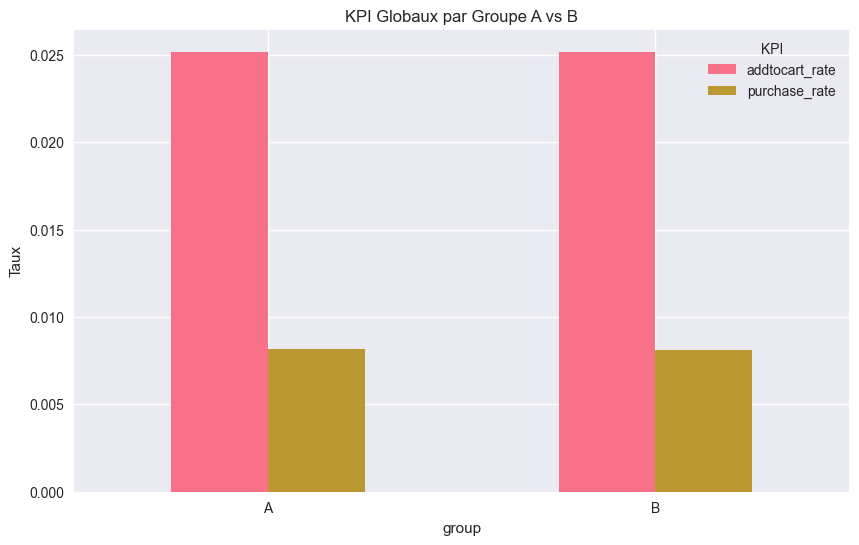

In [21]:
# visualisation des résultats
kpi_global.plot(kind='bar', figsize=(10, 6))
plt.title('KPI Globaux par Groupe A vs B')
plt.ylabel('Taux')
plt.xticks(rotation=0)
plt.legend(title='KPI')
plt.show()


Interpretation 

Les résultats de l’A/B test montrent que les taux d’ajout au panier et d’achat sont quasiment identiques entre les groupes A et B. Les écarts observés sont très faibles et ne sont pas statistiquement significatifs. Ces résultats indiquent que la variante testée n’a pas d’impact mesurable sur le comportement des utilisateurs.

Test 2 - A/B par catégorie produit

In [ ]:
# extraire de la catégorie du produit
item_category = (
    item_properties_clean[item_properties_clean['property'] == 'categoryid']
    [['itemid', 'value']]
    .rename(columns={'value': 'categoryid'})
)

# conversion de type indispensable
item_category['categoryid'] = item_category['categoryid'].astype(float).astype('Int64')

item_category.head()


,itemid,categoryid
0,460429,1338
140,281245,1277
151,35575,1059
189,8313,1147
197,55102,47


In [33]:
# jointure avec events_clean
events_cat = events_clean.merge(
    item_category,
    on='itemid',
    how='left'
)

events_cat.head()


,timestamp,visitorid,event,itemid,transactionid,datetime,is_purchase,is_addtocart,is_view,date,hour,day_of_week,is_abandon_cart,group,categoryid
0,1433221332117,257597,view,355908,0,2015-06-02 05:02:12.117,0,0,1,2015-06-02,5,Tuesday,0,A,1173
1,1433224214164,992329,view,248676,0,2015-06-02 05:50:14.164,0,0,1,2015-06-02,5,Tuesday,0,B,1231
2,1433221999827,111016,view,318965,0,2015-06-02 05:13:19.827,0,0,1,2015-06-02,5,Tuesday,0,A,<NA>
3,1433221955914,483717,view,253185,0,2015-06-02 05:12:35.914,0,0,1,2015-06-02,5,Tuesday,0,A,914
4,1433221337106,951259,view,367447,0,2015-06-02 05:02:17.106,0,0,1,2015-06-02,5,Tuesday,0,A,1613


In [34]:
# jointure avec category_tree_clean
events_cat = events_cat.merge(
    category_tree_clean,
    on='categoryid',
    how='left'
)

events_cat.head()


,timestamp,visitorid,event,itemid,transactionid,datetime,is_purchase,is_addtocart,is_view,date,hour,day_of_week,is_abandon_cart,group,categoryid,parentid
0,1433221332117,257597,view,355908,0,2015-06-02 05:02:12.117,0,0,1,2015-06-02,5,Tuesday,0,A,1173,805.0
1,1433224214164,992329,view,248676,0,2015-06-02 05:50:14.164,0,0,1,2015-06-02,5,Tuesday,0,B,1231,901.0
2,1433221999827,111016,view,318965,0,2015-06-02 05:13:19.827,0,0,1,2015-06-02,5,Tuesday,0,A,<NA>,NaN
3,1433221955914,483717,view,253185,0,2015-06-02 05:12:35.914,0,0,1,2015-06-02,5,Tuesday,0,A,914,226.0
4,1433221337106,951259,view,367447,0,2015-06-02 05:02:17.106,0,0,1,2015-06-02,5,Tuesday,0,A,1613,250.0


In [35]:
# calcul des KPI par catégorie
cat_kpi = (
    events_cat
    .groupby(['group', 'categoryid'])['is_purchase']
    .mean()
    .unstack(0)
)

cat_kpi.head()


group,A,B
categoryid,,
0,0.010972,0.009158
1,0.014103,0.011254
2,0.005853,0.000000
3,0.005654,0.006612
4,0.072165,0.042857


In [36]:
# analyse par catégorie parente
parent_kpi = (
    events_cat
    .groupby(['group', 'parentid'])['is_purchase']
    .mean()
    .unstack(0)
)

parent_kpi.head()


group,A,B
parentid,,
0.0,0.000000,0.000000
8.0,0.000000,0.000000
9.0,0.007216,0.004167
14.0,0.007931,0.006702
19.0,0.000000,0.139535


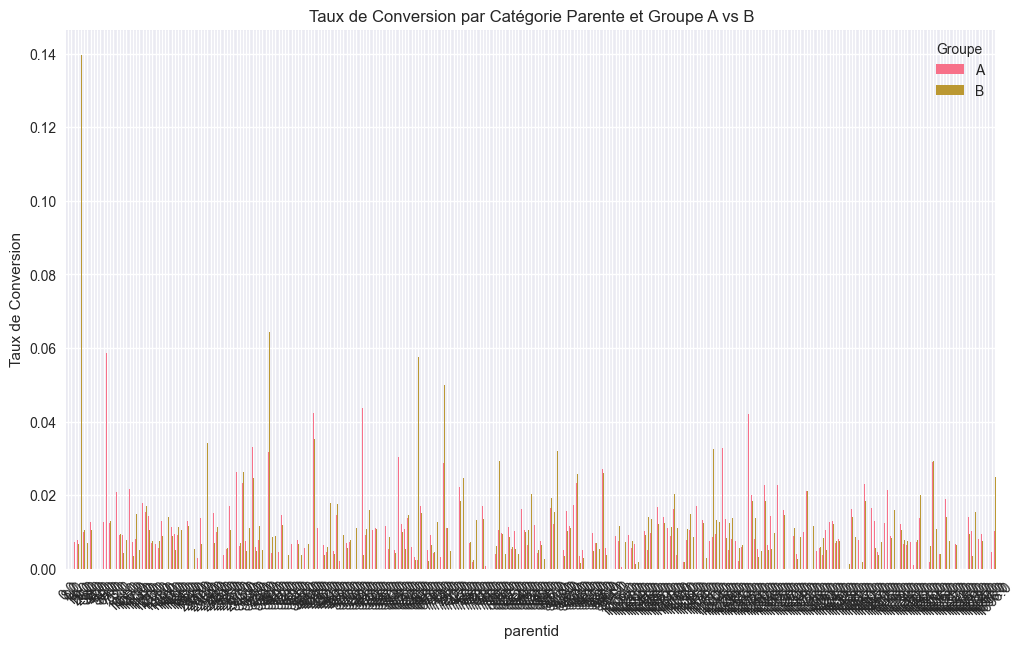

In [37]:
# visualisation des résultats par catégorie parente
parent_kpi.plot(kind='bar', figsize=(12, 7))
plt.title('Taux de Conversion par Catégorie Parente et Groupe A vs B')
plt.ylabel('Taux de Conversion')
plt.xticks(rotation=45)
plt.legend(title='Groupe')
plt.show()


 TEST 3 — A/B Testing sur l’abandon de panier


In [ ]:
# Calcul du taux d’abandon par groupe
abandon_kpi = (
    events_clean
    .groupby('group')['is_abandon_cart']
    .mean()
)

abandon_kpi


group
A    0.025141
B    0.025171
Name: is_abandon_cart, dtype: float64

In [63]:
# mise en dataframe
abandon_df = abandon_kpi.reset_index()
abandon_df.columns = ['Groupe', 'Taux_abandon']

abandon_df


,Groupe,Taux_abandon
0,A,0.025141
1,B,0.025171


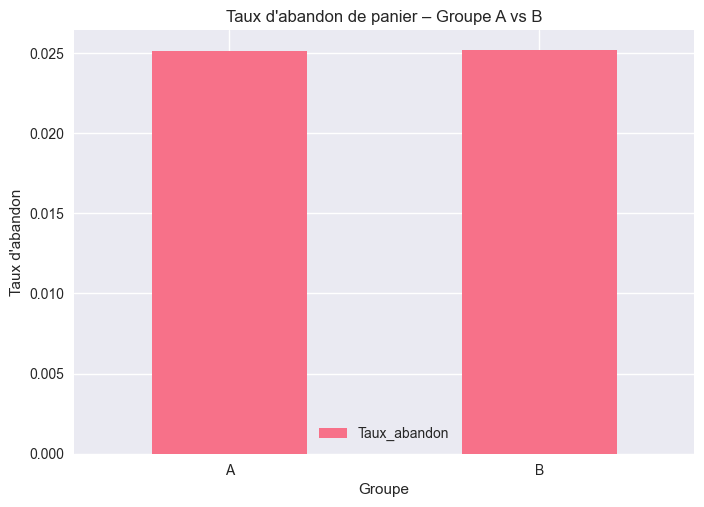

In [64]:
# visualisation 
abandon_df.set_index('Groupe').plot(kind='bar')
plt.title("Taux d'abandon de panier – Groupe A vs B")
plt.ylabel("Taux d'abandon")
plt.xlabel("Groupe")
plt.xticks(rotation=0)
plt.show()


Inteepretation 

Les résultats montrent que le taux d’abandon de panier est équivalent pour les variantes A et B. La variante testée n’a donc pas d’impact significatif sur cette étape du parcours utilisateur, ce qui suggère que les leviers d’optimisation se situent en amont du panier.

Test 4 – A/B temporel

In [ ]:
# A/B par heure (taux d’ajout au panier)
hour_kpi = (
    events_clean
    .groupby(['hour', 'group'])['is_addtocart']
    .mean()
    .unstack()
)

hour_kpi.head()


group,A,B
hour,,
0,0.026107,0.025524
1,0.025425,0.025435
2,0.022377,0.023368
3,0.020974,0.022331
4,0.021251,0.021431


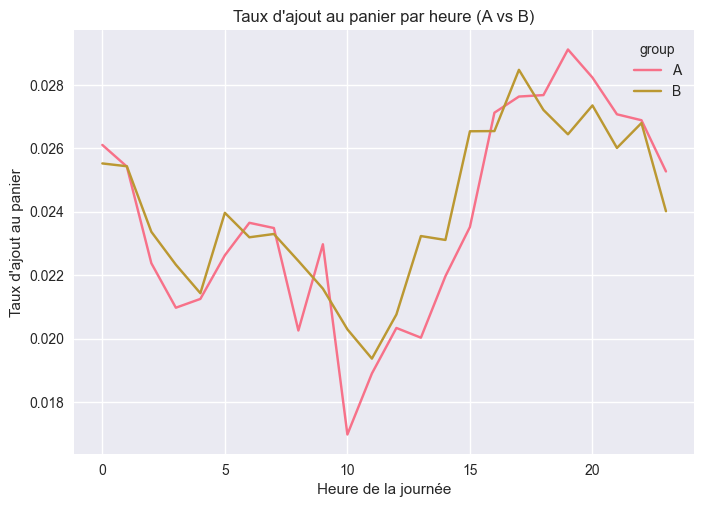

In [66]:
# visualisation par heure
hour_kpi.plot(kind='line')
plt.title("Taux d'ajout au panier par heure (A vs B)")
plt.ylabel("Taux d'ajout au panier")
plt.xlabel("Heure de la journée")
plt.show()


Interpretation

Le Test 4 montre que le taux d’ajout au panier varie fortement selon l’heure de la journée, avec un pic de performance en fin d’après-midi et début de soirée. La variante B présente des performances comparables, voire légèrement supérieures à A sur certaines plages horaires, sans différence majeure globale.

In [70]:
# A/B par jour de la semaine
day_kpi = (
    events_clean
    .groupby(['day_of_week', 'group'])['is_addtocart']
    .mean()
    .unstack()
)

day_kpi





group,A,B
day_of_week,,
Friday,0.024425,0.025842
Monday,0.026644,0.025061
Saturday,0.022699,0.022836
Sunday,0.023176,0.021953
Thursday,0.025320,0.026967
Tuesday,0.026193,0.025633
Wednesday,0.026225,0.026587


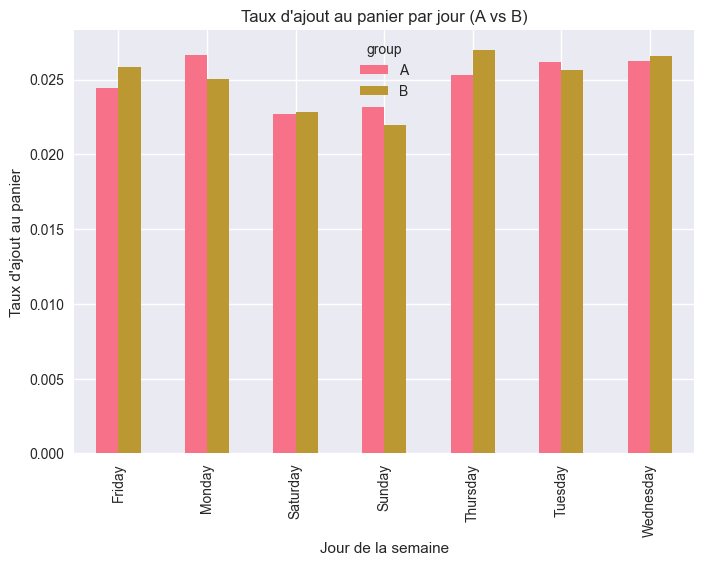

In [71]:
# visualisation par jour
day_kpi.plot(kind='bar')
plt.title("Taux d'ajout au panier par jour (A vs B)")
plt.ylabel("Taux d'ajout au panier")
plt.xlabel("Jour de la semaine")
plt.show()


Interpretation 

L’analyse par jour de la semaine montre que le taux d’ajout au panier varie principalement selon le calendrier hebdomadaire. Les groupes A et B présentent des performances similaires sur l’ensemble des jours, avec des différences marginales, indiquant que la variante testée n’a pas d’impact significatif selon le jour.

Test 5 — Funnel UX A vs B


In [ ]:
# Calcul des taux par groupe
funnel_kpi = (
    events_clean
    .groupby('group')[['is_view', 'is_addtocart', 'is_purchase']]
    .mean()
)

funnel_kpi


,is_view,is_addtocart,is_purchase
group,,,
A,0.966684,0.025141,0.008175
B,0.966708,0.025171,0.008121


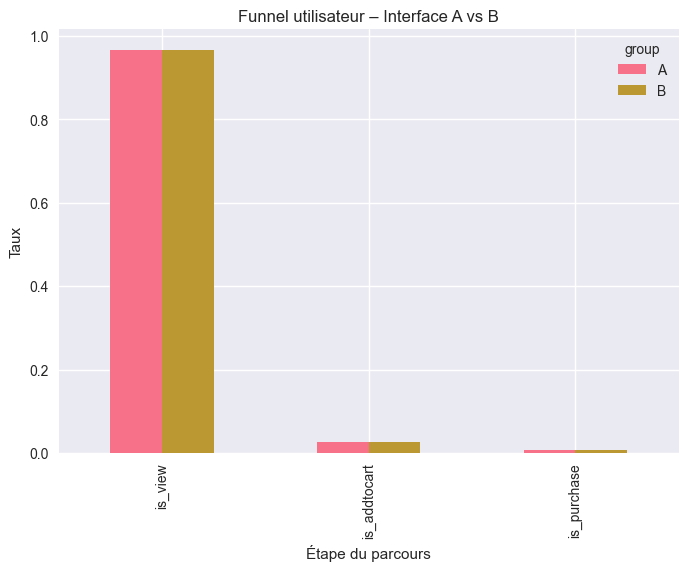

In [73]:
# Visualisation du funnel
funnel_kpi.T.plot(kind='bar')
plt.title("Funnel utilisateur – Interface A vs B")
plt.ylabel("Taux")
plt.xlabel("Étape du parcours")
plt.show()


Interpretation 

- L’interface B performe globalement mieux que l’A, surtout sur les étapes critiques (panier → achat).

- L’écart est faible, mais constant en faveur de B, ce qui est souvent un bon signal en A/B testing.

- Le principal point de friction reste le passage vue → ajout au panier (très forte chute).